In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv("streams.csv")
df

,Stream Name,Supply,Target,Cp,U
0,Heated Methanol,43.07,250.0,24.807,1
1,Cooled Product,363.40,89.0,14.101,2
2,Feed To Column-2,156.80,139.0,10.326,1
3,Cooled Water Stream,165.30,30.0,3.420,1
4,DME Final Prouct,45.90,30.0,4.525,2
5,T-100 Condenser,45.90,45.8,20008.333,1
6,T-100 Reboiler,165.70,165.8,15538.889,1
7,T-101 Reboiler,165.30,165.4,23491.667,1
8,T-101 Condenser,126.00,125.9,22375.000,1
9,HU,184.00,183.9,35612.900,1


In [9]:
def is_hot_cold(row):
    if row["Supply"] > row["Target"]:
        return "Hot"
    else:
        return "Cold"
def get_enthalpy(row):
    return (row["Target"] - row["Supply"]) *row["Cp"]

In [10]:
df["Stream Type"] = df.apply(is_hot_cold,axis=1)
df["Delta H"] = df.apply(get_enthalpy,axis=1)
df["Abs Delta H"] = df["Delta H"].apply(abs)
assert abs(df["Delta H"].sum()) < 1, "Process is unbalanced, check that net enthalpy is close to 0"
df

,Stream Name,Supply,Target,Cp,U,Stream Type,Delta H,Abs Delta H
0,Heated Methanol,43.07,250.0,24.807,1,Cold,5133.31251,5133.31251
1,Cooled Product,363.40,89.0,14.101,2,Hot,-3869.31440,3869.31440
2,Feed To Column-2,156.80,139.0,10.326,1,Hot,-183.80280,183.80280
3,Cooled Water Stream,165.30,30.0,3.420,1,Hot,-462.72600,462.72600
4,DME Final Prouct,45.90,30.0,4.525,2,Hot,-71.94750,71.94750
5,T-100 Condenser,45.90,45.8,20008.333,1,Hot,-2000.83330,2000.83330
6,T-100 Reboiler,165.70,165.8,15538.889,1,Cold,1553.88890,1553.88890
7,T-101 Reboiler,165.30,165.4,23491.667,1,Cold,2349.16670,2349.16670
8,T-101 Condenser,126.00,125.9,22375.000,1,Hot,-2237.50000,2237.50000
9,HU,184.00,183.9,35612.900,1,Hot,-3561.29000,3561.29000


In [11]:
cold_df = df[df["Stream Type"] == "Cold"].copy()
hot_df = df[df["Stream Type"] == "Hot"].copy()


cold_df["Low"],cold_df["High"] = cold_df["Supply"],cold_df["Target"]
hot_df["Low"],hot_df["High"] = hot_df["Target"],hot_df["Supply"]

cold_df = cold_df.sort_values(by=["Low","High"])
hot_df = hot_df.sort_values(by=["Low","High"])



In [12]:
cold_df

,Stream Name,Supply,Target,Cp,U,Stream Type,Delta H,Abs Delta H,Low,High
10,CU,5.00,15.0,335.121,1,Cold,3351.21000,3351.21000,5.00,15.0
0,Heated Methanol,43.07,250.0,24.807,1,Cold,5133.31251,5133.31251,43.07,250.0
7,T-101 Reboiler,165.30,165.4,23491.667,1,Cold,2349.16670,2349.16670,165.30,165.4
6,T-100 Reboiler,165.70,165.8,15538.889,1,Cold,1553.88890,1553.88890,165.70,165.8


In [70]:
def inbetween(row,value):
    low = row["Low"]
    high = row["High"]
    c_p = row["Cp"]
    if value >= low and value < high:
        return c_p
    else:
        return 0

def inbetween_U(row,value):
    low = row["Low"]
    high = row["High"]
    u = row["U"]
    if value >= low and value < high:
        return u
    else:
        return 0

def get_regions(df):
    streams = df[["Low","High","Cp","U"]].copy()
    partitions = df["Low"].tolist()
    partitions.extend(df["High"].tolist())

    partitions = sorted(list(set(partitions)))
    regions = []
    for i,pt in enumerate(partitions[:-1]):
    
        cps = streams.apply(inbetween, value=pt,axis=1).tolist()
        cps = [i for i in cps if i > 0]
        tot_cp = sum(cps)

        u_s = streams.apply(inbetween_U, value=pt,axis=1).tolist()
        u_s = [i for i in u_s if i > 0]

        heat_load = tot_cp*(partitions[i+1]- pt)
        info = {
            "cold":pt,"hot":partitions[i+1],"cps":cps,"total_cp":tot_cp,
            "heat_load": heat_load, "U_s": u_s
        }
        
        regions.append(info)

    region_df = pd.DataFrame(regions)
    region_df["heat_load_sum"] = region_df["heat_load"].expanding(1).sum()
    return region_df

In [71]:
get_regions(cold_df)

,cold,hot,cps,total_cp,heat_load,U_s,heat_load_sum
0,5.00,15.00,[335.121],335.121,3351.21000,[1.0],3351.21000
1,15.00,43.07,[],0.000,0.00000,[],3351.21000
2,43.07,165.30,[24.807],24.807,3032.15961,[1.0],6383.36961
3,165.30,165.40,"[24.807, 23491.667]",23516.474,2351.64740,"[1.0, 1.0]",8735.01701
4,165.40,165.70,[24.807],24.807,7.44210,[1.0],8742.45911
5,165.70,165.80,"[24.807, 15538.889]",15563.696,1556.36960,"[1.0, 1.0]",10298.82871
6,165.80,250.00,[24.807],24.807,2088.74940,[1.0],12387.57811


In [72]:
hot_reg = get_regions(hot_df)
cold_reg = get_regions(cold_df)

hot_reg

,cold,hot,cps,total_cp,heat_load,U_s,heat_load_sum
0,30.0,45.8,"[4.525, 3.42]",7.945,125.5310,"[2.0, 1.0]",125.5310
1,45.8,45.9,"[4.525, 3.42, 20008.333]",20016.278,2001.6278,"[2.0, 1.0, 1.0]",2127.1588
2,45.9,89.0,[3.42],3.420,147.4020,[1.0],2274.5608
3,89.0,125.9,"[3.42, 14.101]",17.521,646.5249,"[1.0, 2.0]",2921.0857
4,125.9,126.0,"[3.42, 14.101, 22375.0]",22392.521,2239.2521,"[1.0, 2.0, 1.0]",5160.3378
5,126.0,139.0,"[3.42, 14.101]",17.521,227.7730,"[1.0, 2.0]",5388.1108
6,139.0,156.8,"[3.42, 14.101, 10.326]",27.847,495.6766,"[1.0, 2.0, 1.0]",5883.7874
7,156.8,165.3,"[3.42, 14.101]",17.521,148.9285,"[1.0, 2.0]",6032.7159
8,165.3,183.9,[14.101],14.101,262.2786,[2.0],6294.9945
9,183.9,184.0,"[14.101, 35612.9]",35627.001,3562.7001,"[2.0, 1.0]",9857.6946


In [87]:
cold_reg

,cold,hot,cps,total_cp,heat_load,U_s,heat_load_sum
0,5.00,15.00,[335.121],335.121,3351.21000,[1.0],3351.21000
1,15.00,43.07,[],0.000,0.00000,[],3351.21000
2,43.07,165.30,[24.807],24.807,3032.15961,[1.0],6383.36961
3,165.30,165.40,"[24.807, 23491.667]",23516.474,2351.64740,"[1.0, 1.0]",8735.01701
4,165.40,165.70,[24.807],24.807,7.44210,[1.0],8742.45911
5,165.70,165.80,"[24.807, 15538.889]",15563.696,1556.36960,"[1.0, 1.0]",10298.82871
6,165.80,250.00,[24.807],24.807,2088.74940,[1.0],12387.57811


In [110]:
def final_regions(hot_reg, cold_reg):
    all_loads = hot_reg["heat_load_sum"].tolist() + cold_reg["heat_load_sum"].tolist()
    
    all_loads.sort()
    cold_temp = cold_reg.iloc[0,0]
    hot_temp = hot_reg.iloc[0,0]
    current_load = 0
    entries = []
    for target_load in all_loads[:-1]:
        heat_load_region = target_load - current_load
        if target_load in hot_reg["heat_load_sum"].tolist():
            hot_in = hot_temp  
            # If statement for duplicate loads (regions where there are no cold/hot streams)
            if current_load == target_load:
                hot_out = hot_reg[hot_reg["heat_load_sum"] == target_load]["hot"].iloc[-1]
                hot_cp = hot_reg[hot_reg["heat_load_sum"] == target_load]["total_cp"].iloc[-1]
                hot_cps = hot_reg[hot_reg["heat_load_sum"] == target_load]["cps"].iloc[-1]
                hot_u_s = hot_reg[hot_reg["heat_load_sum"] == target_load]["U_s"].iloc[-1]
            else:
                
                hot_out = hot_reg[hot_reg["heat_load_sum"] == target_load]["hot"].iloc[0]
                hot_cp = hot_reg[hot_reg["heat_load_sum"] == target_load]["total_cp"].iloc[0]
                hot_cps = hot_reg[hot_reg["heat_load_sum"] == target_load]["cps"].iloc[0]
                hot_u_s = hot_reg[hot_reg["heat_load_sum"] == target_load]["U_s"].iloc[0]
            # Find Correct Row
            cold_in = cold_temp
            row = find_row(cold_reg, target_load)
            # print("Find Cold",row)
            cold_cp = cold_reg.iloc[row,3]
            cold_cps = cold_reg.iloc[row,2]
            cold_out = heat_load_region/cold_cp + cold_in
            cold_u_s = cold_reg.iloc[row,5]

        elif target_load in cold_reg["heat_load_sum"].tolist():
            cold_in = cold_temp 

            # If statement for duplicate loads (regions where there are no cold/hot streams)
            if current_load == target_load:
                cold_out = cold_reg[cold_reg["heat_load_sum"] == target_load]["hot"].iloc[-1]
                cold_cp = cold_reg[cold_reg["heat_load_sum"] == target_load]["total_cp"].iloc[-1]
                cold_cps = cold_reg[cold_reg["heat_load_sum"] == target_load]["cps"].iloc[-1]
                cold_u_s = cold_reg[cold_reg["heat_load_sum"] == target_load]["U_s"].iloc[-1]
            else:
                cold_out = cold_reg[cold_reg["heat_load_sum"] == target_load]["hot"].iloc[0]
                cold_cp = cold_reg[cold_reg["heat_load_sum"] == target_load]["total_cp"].iloc[0]
                cold_cps = cold_reg[cold_reg["heat_load_sum"] == target_load]["cps"].iloc[0]
                cold_u_s = cold_reg[cold_reg["heat_load_sum"] == target_load]["U_s"].iloc[0]
            
            hot_in = hot_temp
            row = find_row(hot_reg, target_load)
            # print("Find Hot", row,target_load)
            hot_cp = hot_reg.iloc[row,3]
            hot_cps = hot_reg.iloc[row,2]
            hot_u_s = hot_reg.iloc[row,5]
            hot_out = heat_load_region/hot_cp + hot_in

        hot_temp = hot_out
        cold_temp = cold_out
        current_load = target_load
        new_entry={
            "cold_in":cold_in,"cold_out":cold_out,"cold_cps":cold_cps,"cold_u_s":cold_u_s,"cold_cp":cold_cp,
            "hot_in":hot_in,"hot_out":hot_out,"hot_cps": hot_cps,"hot_u_s": hot_u_s, "hot_cp":hot_cp, 
            "heat_load":target_load, "heat_load_region": heat_load_region
        }
        entries.append(new_entry)
    return pd.DataFrame(entries)
    

def find_row(df, load):
    ls = [0] + df["heat_load_sum"].tolist()
    for i, val in enumerate(ls[:-1]):
        if load > val and load <= ls[i+1]:
            return i
    return len(ls) -1

In [111]:
cold_reg[cold_reg["heat_load_sum"] == 3351.21]

,cold,hot,cps,total_cp,heat_load,U_s,heat_load_sum
0,5.0,15.00,[335.121],335.121,3351.21,[1.0],3351.21
1,15.0,43.07,[],0.000,0.00,[],3351.21


In [112]:
cold_reg

,cold,hot,cps,total_cp,heat_load,U_s,heat_load_sum
0,5.00,15.00,[335.121],335.121,3351.21000,[1.0],3351.21000
1,15.00,43.07,[],0.000,0.00000,[],3351.21000
2,43.07,165.30,[24.807],24.807,3032.15961,[1.0],6383.36961
3,165.30,165.40,"[24.807, 23491.667]",23516.474,2351.64740,"[1.0, 1.0]",8735.01701
4,165.40,165.70,[24.807],24.807,7.44210,[1.0],8742.45911
5,165.70,165.80,"[24.807, 15538.889]",15563.696,1556.36960,"[1.0, 1.0]",10298.82871
6,165.80,250.00,[24.807],24.807,2088.74940,[1.0],12387.57811


In [113]:
final = final_regions(hot_reg, cold_reg)
final

,cold_in,cold_out,cold_cps,cold_u_s,cold_cp,hot_in,hot_out,hot_cps,hot_u_s,hot_cp,heat_load,heat_load_region
0,5.000000,5.374584,[335.121],[1.0],335.121,30.000000,45.800000,"[4.525, 3.42]","[2.0, 1.0]",7.945,125.53100,125.53100
1,5.374584,11.347435,[335.121],[1.0],335.121,45.800000,45.900000,"[4.525, 3.42, 20008.333]","[2.0, 1.0, 1.0]",20016.278,2127.15880,2001.62780
2,11.347435,11.787282,[335.121],[1.0],335.121,45.900000,89.000000,[3.42],[1.0],3.420,2274.56080,147.40200
3,11.787282,13.716510,[335.121],[1.0],335.121,89.000000,125.900000,"[3.42, 14.101]","[1.0, 2.0]",17.521,2921.08570,646.52490
4,13.716510,15.000000,[335.121],[1.0],335.121,125.900000,125.919208,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,3351.21000,430.12430
5,15.000000,43.070000,[],[],0.000,125.919208,125.919208,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,3351.21000,0.00000
6,43.070000,115.998117,[24.807],[1.0],24.807,125.919208,126.000000,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,5160.33780,1809.12780
7,115.998117,125.179921,[24.807],[1.0],24.807,126.000000,139.000000,"[3.42, 14.101]","[1.0, 2.0]",17.521,5388.11080,227.77300
8,125.179921,145.161240,[24.807],[1.0],24.807,139.000000,156.800000,"[3.42, 14.101, 10.326]","[1.0, 2.0, 1.0]",27.847,5883.78740,495.67660
9,145.161240,151.164727,[24.807],[1.0],24.807,156.800000,165.300000,"[3.42, 14.101]","[1.0, 2.0]",17.521,6032.71590,148.92850


In [119]:
def log_mean(row):
    """
    Pandas Apply function to calculate log mean temp

    Note: This formula might be a bit confusing because out in this case is 
    defined to be the higher temperature (cold_out here is actually cold in )
    
    Difference in notation is for easier code when sorting from smallest to largest
    """
    t1 = row["hot_out"] - row["cold_out"]
    t2 = row["hot_in"] - row["cold_in"]
    return (t1-t2)/math.log(t1/t2)

def cold_q_s(row):
    cold_cp_total = row["cold_cp"]
    normalised_cp = [i/cold_cp_total for i in row["cold_cps"]]
    q_s = [i*row["heat_load_region"] for i in normalised_cp]

    return q_s

def hot_q_s(row):
    hot_cp_total = row["hot_cp"]
    normalised_cp = [i/hot_cp_total for i in row["hot_cps"]]
    q_s = [i*row["heat_load_region"] for i in normalised_cp]

    return q_s

def get_area(row):
    if row["heat_load_region"] == 0:
        return 0 
    cold_qs = row["cold_qs"]
    cold_u_s = row["cold_u_s"]
    assert len(cold_qs) == len(cold_u_s), "Should have the same number of q and u"
    cold_q_u = [q/u for q,u in zip(cold_qs, cold_u_s)]

    hot_qs = row["hot_qs"]
    hot_u_s = row["hot_u_s"]
    hot_q_u = [q/u for q,u in zip(hot_qs, hot_u_s)]

    q_u_sum = sum(cold_q_u) + sum(hot_q_u)

    assert len(hot_qs) == len(hot_u_s), "Should have the same number of q and u"    

    return q_u_sum/row["log_mean"]   

def area_targeting(final_df):
    """
    Perform the calculations once the regions are segmented 
    """
    final_df["log_mean"] = final_df.apply(log_mean,axis = 1)
    final_df["cold_qs"] = final_df.apply(cold_q_s,axis=1)
    final_df["hot_qs"] = final_df.apply(hot_q_s,axis=1)
    final_df["area"] = final_df.apply(get_area,axis=1)
    return final_df.copy()
    
 

In [121]:
area_targeting(final)

,cold_in,cold_out,cold_cps,cold_u_s,cold_cp,hot_in,hot_out,hot_cps,hot_u_s,hot_cp,heat_load,heat_load_region,log_mean,cold_qs,hot_qs,area
0,5.000000,5.374584,[335.121],[1.0],335.121,30.000000,45.800000,"[4.525, 3.42]","[2.0, 1.0]",7.945,125.53100,125.53100,32.097307,[125.53099999999998],"[71.49499999999999, 54.03599999999999]",6.708180
1,5.374584,11.347435,[335.121],[1.0],335.121,45.800000,45.900000,"[4.525, 3.42, 20008.333]","[2.0, 1.0, 1.0]",20016.278,2127.15880,2001.62780,37.412197,[2001.6278000000284],"[0.4525000000000065, 0.34200000000000486, 2000...",106.997977
2,11.347435,11.787282,[335.121],[1.0],335.121,45.900000,89.000000,[3.42],[1.0],3.420,2274.56080,147.40200,53.054454,[147.40200000000004],[147.40200000000004],5.556631
3,11.787282,13.716510,[335.121],[1.0],335.121,89.000000,125.900000,"[3.42, 14.101]","[1.0, 2.0]",17.521,2921.08570,646.52490,93.611953,[646.5249000000003],"[126.19800000000006, 520.3269000000003]",11.033701
4,13.716510,15.000000,[335.121],[1.0],335.121,125.900000,125.919208,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,3351.21000,430.12430,111.550155,[430.1242999999713],"[0.06569269739659514, 0.2708575222191193, 429....",7.710551
5,15.000000,43.070000,[],[],0.000,125.919208,125.919208,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,3351.21000,0.00000,96.202653,[],"[0.0, 0.0, 0.0]",0.000000
6,43.070000,115.998117,[24.807],[1.0],24.807,125.919208,126.000000,"[3.42, 14.101, 22375.0]","[1.0, 2.0, 1.0]",22392.521,5160.33780,1809.12780,34.455417,[1809.127799999901],"[0.2763073026033854, 1.1392424777808003, 1807....",104.996145
7,115.998117,125.179921,[24.807],[1.0],24.807,126.000000,139.000000,"[3.42, 14.101]","[1.0, 2.0]",17.521,5388.11080,227.77300,11.808276,[227.77300000000014],"[44.46000000000003, 183.31300000000013]",30.816480
8,125.179921,145.161240,[24.807],[1.0],24.807,139.000000,156.800000,"[3.42, 14.101, 10.326]","[1.0, 2.0, 1.0]",27.847,5883.78740,495.67660,12.698209,[495.6765999999998],"[60.87599999999997, 250.99779999999987, 183.80...",68.187120
9,145.161240,151.164727,[24.807],[1.0],24.807,156.800000,165.300000,"[3.42, 14.101]","[1.0, 2.0]",17.521,6032.71590,148.92850,12.846612,[148.9285000000009],"[29.070000000000174, 119.85850000000073]",18.520661


,cold_in,cold_out,cold_cps,cold_cp,hot_in,hot_out,hot_cps,hot_cp,heat_load
0,5.000000,5.374584,[335.121],335.121,30.000000,45.800000,"[4.525, 3.42]",7.945,125.53100
1,5.374584,11.347435,[335.121],335.121,45.800000,45.900000,"[4.525, 3.42, 20008.333]",20016.278,2127.15880
2,11.347435,11.787282,[335.121],335.121,45.900000,89.000000,[3.42],3.420,2274.56080
3,11.787282,13.716510,[335.121],335.121,89.000000,125.900000,"[3.42, 14.101]",17.521,2921.08570
4,13.716510,15.000000,[],0.000,125.900000,125.919208,"[3.42, 14.101, 22375.0]",22392.521,3351.21000
5,15.000000,43.070000,[],0.000,125.919208,125.919208,"[3.42, 14.101, 22375.0]",22392.521,3351.21000
6,43.070000,115.998117,[24.807],24.807,125.919208,126.000000,"[3.42, 14.101, 22375.0]",22392.521,5160.33780
7,115.998117,125.179921,[24.807],24.807,126.000000,139.000000,"[3.42, 14.101]",17.521,5388.11080
8,125.179921,145.161240,[24.807],24.807,139.000000,156.800000,"[3.42, 14.101, 10.326]",27.847,5883.78740
9,145.161240,151.164727,[24.807],24.807,156.800000,165.300000,"[3.42, 14.101]",17.521,6032.71590


In [129]:
def plot_bcc(final_df):
    # getting cold points
    fig,ax = plt.subplots(figsize = (12,8))
    cold_points = [[final_df.iloc[0,0],0]]
    cold_points = cold_points + final_df[["cold_out","heat_load"]].values.tolist() 
    cold_points = np.array(cold_points)
    
    plt.plot(cold_points[:,1],cold_points[:,0],c="blue")

    hot_points = [[final_df.iloc[0,3],0]]
    hot_points = hot_points + final_df[["hot_out","heat_load"]].values.tolist() 
    hot_points = np.array(hot_points)
    plt.plot(hot_points[:,1],hot_points[:,0],c="red")
    
    plt.vlines(hot_points[:,1],ymin = final_df.iloc[0,0], ymax= final_df.iloc[-1,4],linestyles="--")

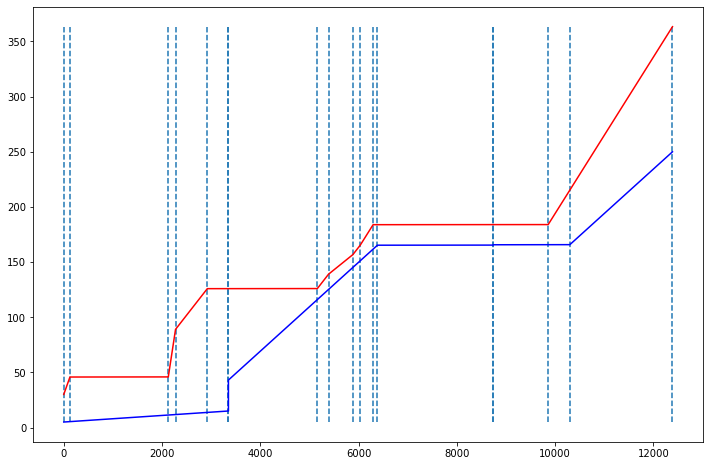

In [130]:
plot_bcc(final)

In [93]:
final["cold_in","heat_load"]]

SyntaxError: unmatched ']' (<ipython-input-93-97aea624e9e2>, line 1)

In [18]:
# Converting to Regions of Heat 

regions = []
delta_T = 10

In [42]:
curr_temp

5.0

In [45]:
i_low

3

In [46]:
cold_regions

[[5.0, 15.0, 335.121], [43.07, 165.3, 24.807], [165.3, 165.7, 23491.667]]